In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from kerastuner.tuners import BayesianOptimization
from kerastuner import HyperModel
import tensorflow as tf
import random

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Load and preprocess the data
def load_data(file_path):
    df = pd.read_csv(file_path)
    data = df[['Open', 'High', 'Low', 'Close', 'Volume', 'fear-greed']].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

def create_dataset(data, time_step):
    x, y = [], []
    for i in range(len(data) - time_step - 1):
        x.append(data[i:(i + time_step)])
        y.append(data[i + time_step, 3])  # Index 3 corresponds to the 'Close' price
    return np.array(x), np.array(y)

file_path = 'dataset.csv'  # Replace with your dataset
data, scaler = load_data(file_path)

time_step = 60  # Number of time steps to look back
x, y = create_dataset(data, time_step)
x = np.reshape(x, (x.shape[0], x.shape[1], x.shape[2]))

# Split data into train, validation, and test sets
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = len(data) - train_size - val_size

train_data = data[:train_size]
val_data = data[train_size - time_step:train_size + val_size]
test_data = data[train_size + val_size - time_step:]

x_train, y_train = create_dataset(train_data, time_step)
x_val, y_val = create_dataset(val_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], x_val.shape[2]))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

# Define the model for Keras Tuner
class LSTMHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(LSTM(units=hp.Int('units_1', min_value=32, max_value=256, step=32), return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
        model.add(Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
        model.add(LSTM(units=hp.Int('units_2', min_value=32, max_value=256, step=32), return_sequences=False))
        model.add(Dropout(hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))
        model.add(Dense(units=hp.Int('units_3', min_value=16, max_value=128, step=16)))
        model.add(Dense(units=1))

        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

# Perform hyperparameter tuning with Keras Tuner
tuner = BayesianOptimization(
    LSTMHyperModel(),
    objective='val_loss',
    max_trials=20,
    executions_per_trial=2,
    directory='lstm_tuning',
    project_name='stock_prediction'
)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Search for the best hyperparameters
tuner.search(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping, reduce_lr])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on the test set
predictions = best_model.predict(x_test)
predictions = scaler.inverse_transform(np.concatenate([np.zeros((predictions.shape[0], data.shape[1]-1)), predictions], axis=1))[:, -1]

Trial 20 Complete [00h 07m 54s]
val_loss: 0.0006246218108572066

Best val_loss So Far: 0.0006246218108572066
Total elapsed time: 01h 23m 27s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Mean Squared Error (MSE): 3.4554963818825026
Root Mean Squared Error (RMSE): 1.8588965495375214
Mean Absolute Error (MAE): 1.5159165444263516
R-squared (R²) Score: 0.8896440082991067
Mean Absolute Percentage Error (MAPE): 2.1688392532290535%


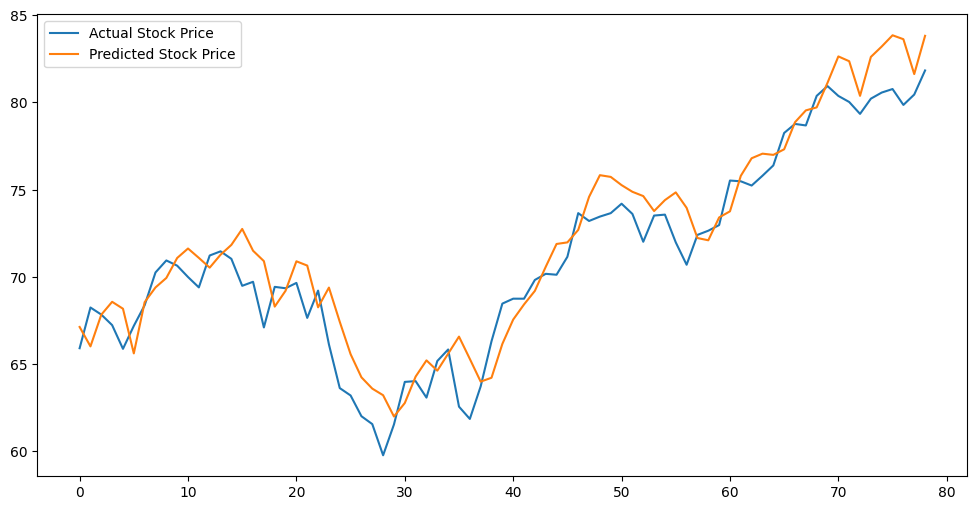

In [3]:
# Inverse transform y_test
y_test = scaler.inverse_transform(np.concatenate([np.zeros((y_test.shape[0], data.shape[1]-1)), y_test.reshape(-1, 1)], axis=1))[:, -1]

# Evaluate model performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²) Score: {r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100}%")

# Optional: Visualize predictions and actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Stock Price')
plt.plot(predictions, label='Predicted Stock Price')
plt.legend()
plt.show()